# Next: isolate visual stim with no turn response
# isolate spontaneous turns
# make time traces of each roi

In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d


In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_134/func_0/'

In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [45]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [5]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)

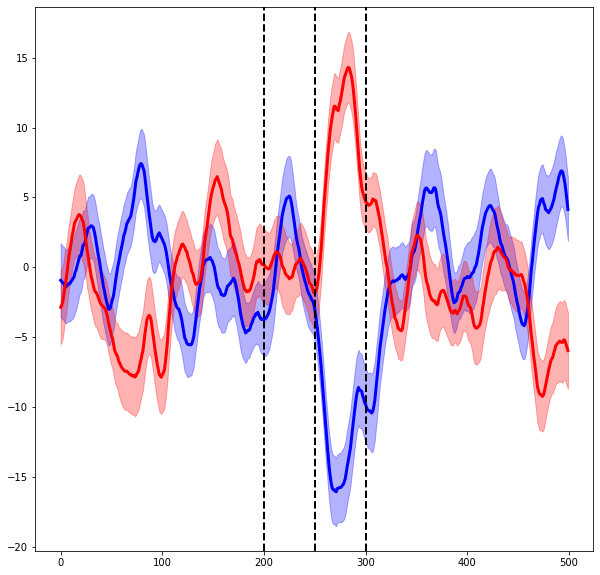

In [6]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [7]:
#####################################
### Extract Visually Evoked Turns ###
#####################################
#fly 134
#r_thresh=.3, 
#av_thresh=50,


ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                      start=250, 
                                                                      stop=300, 
                                                                      r_thresh=.3, 
                                                                      av_thresh=50, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)

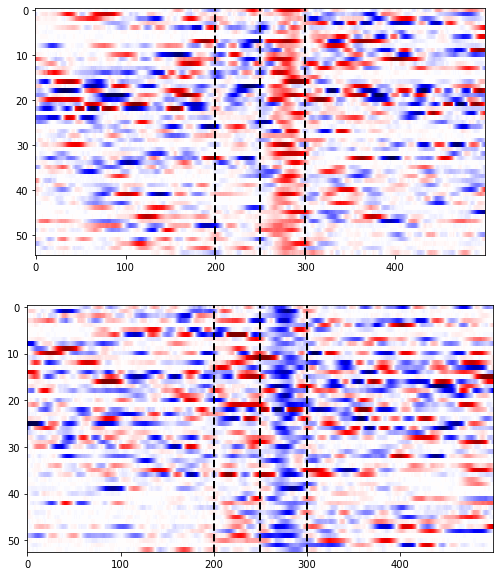

In [8]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

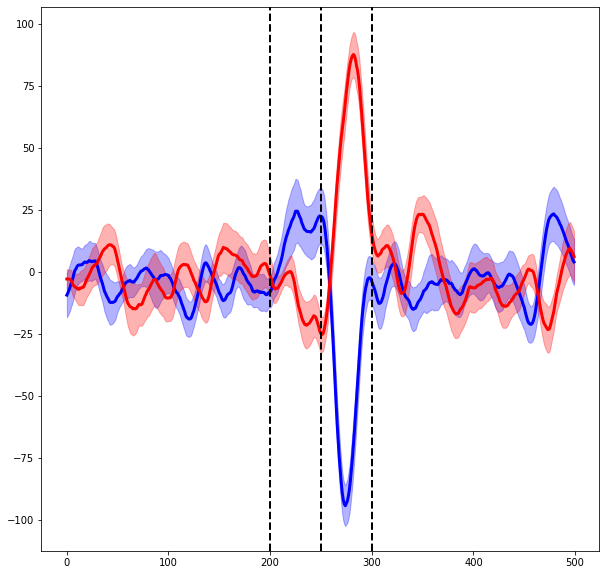

In [9]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [10]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [11]:
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
                                  start=250,
                                  stop=300,
                                  num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
                                  stim_times=starts_angle_ms[angle])

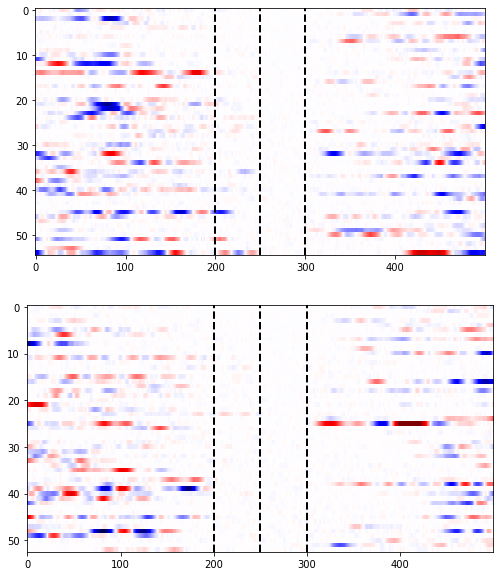

In [12]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

(-50, 50)

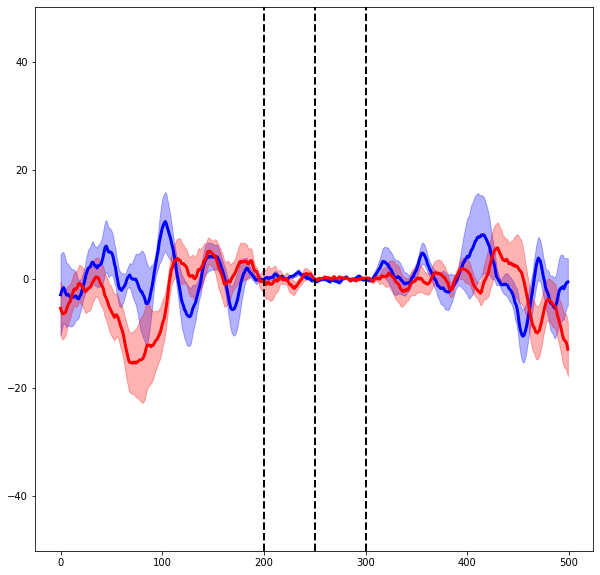

In [13]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

# extract grey baseline

In [46]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [52]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
# *1000 puts in units of ms, which will match neural timestamps
grey_starts = [i*1000 for i in grey_starts]
grey_stops = [i*1000 for i in grey_stops]

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

# idx_to_use = []
# for i in range(len(grey_starts)):
#     idx_to_use.extend(np.where((grey_starts[i] < timestamps[:,0]) & (timestamps[:,0] < grey_stops[i]))[0])

In [51]:
grey_starts

[1309.1999999999998, 444198.8, 887138.4, 1329944.7, 1772859.3]

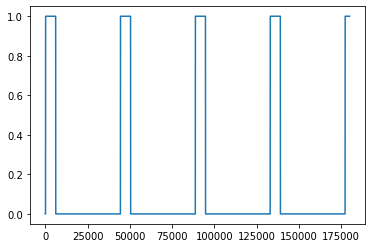

In [53]:
plt.plot(grey_periods)

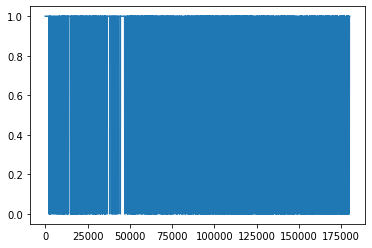

In [61]:
plt.plot(walking)

In [63]:
np.sum(walking==0), np.sum(walking==1)

(57311, 122689)

In [85]:
for z in range(49):
    idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
    grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
    grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
    all_signals

In [88]:
all_signals.shape

(49, 2000, 3384)

In [86]:
np.sum(grey_and_stopped), np.sum(grey_and_walking)

(160, 342)

# load neural

In [14]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [15]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [16]:
fixed = brainsss.load_fda_meanbrain()

In [17]:
atlas = brainsss.load_roi_atlas()

In [18]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [89]:
bin_start = -500; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# STA analysis

In [16]:
angle = 180

STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = starts_angle_ms[angle],
                                   neural_bins = neural_bins)

In [17]:
reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)

In [18]:
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [20]:
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')

In [23]:
len(neural_bins)

9

In [24]:
explosions = []
for tp in range(len(neural_bins)-1):
    input_canvas = np.zeros((500,500,3))
    data_to_plot = warps[tp][:,:,::-1]# - warps[0][:,:,::-1]
    vmax = 0.5

    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='hot')
    explosions.append(explosion_map)

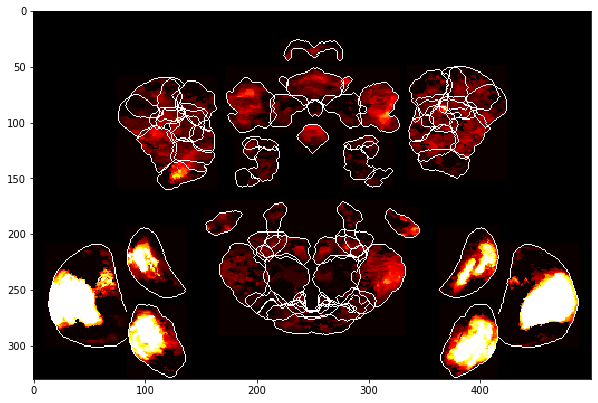

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(explosions[7][170:,:])

# STA wrapped

In [22]:
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(24):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

ve_no_0
STA 1.249084711074829
Warps 64.76805806159973
Explosion 46.55503797531128
ve_no_180
STA 1.2412827014923096
Warps 68.53913736343384
Explosion 46.73633933067322
ve_0
STA 1.1893815994262695
Warps 81.47812247276306
Explosion 46.84498572349548
ve_180
STA 1.2154333591461182
Warps 121.78571557998657
Explosion 46.555198192596436


In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

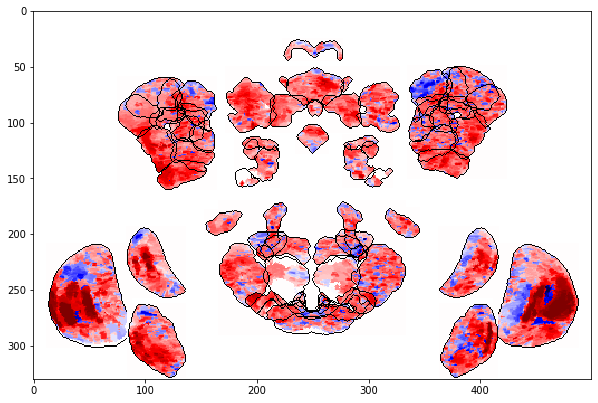

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(all_explosions['ve_0'][10][170:,:])

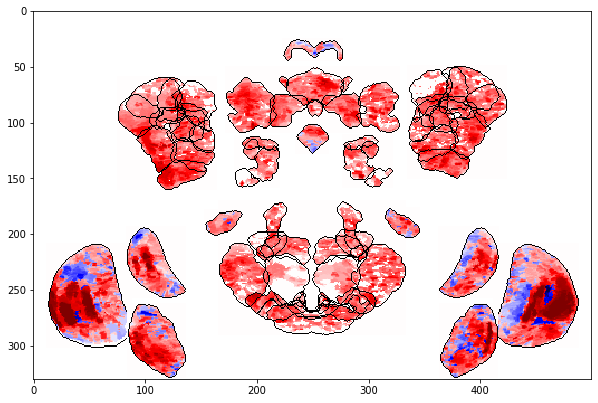

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(all_explosions['ve_0'][10][170:,:])

In [ ]:
### get grey baseline

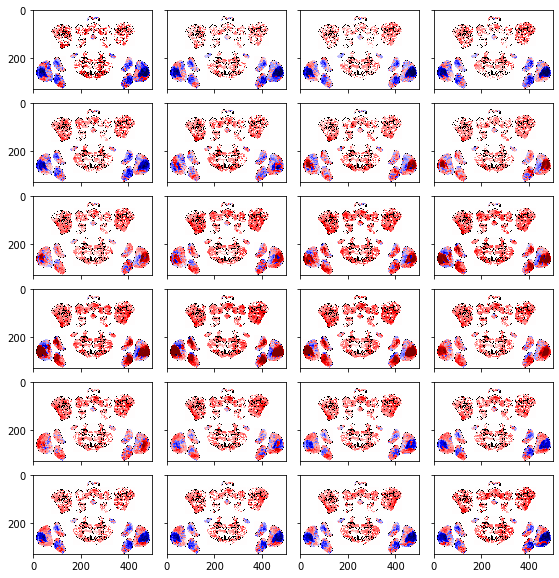

In [25]:
fig = plt.figure(figsize=(10,10))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 4), axes_pad=.2)
for i in range(24):
    grid[i].imshow(all_explosions['ve_0'][i][170:,:])

In [23]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='w',y=.93,fontsize=12)
    plt.axis('off')

In [24]:
for tp in range(24):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_no_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='white')
    plot_panel('ve_no_180', tp, 2)
    plot_panel('ve_0', tp, 3)
    plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle('20220502_fly_134',y=.9)


    cax = fig.add_axes([0.47, 0.66, 0.01, 0.2])
    cmap = matplotlib.cm.hot
    norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
    cb = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')

    cb.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white',fontsize=12);
    cb.outline.set_edgecolor('white')
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220504a_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [35]:
os.mkdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220502a_movie')

In [36]:
for tp in range(24):
    print(tp)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(explosions[tp][170:,:])
    plt.title('Fly 153, STA Angle == 0, SuperVox, temporal smooth',color='w',y=.93,fontsize=12)
    plt.axis('off')

    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='white')

    cax = fig.add_axes([0.79, 0.5, 0.05, 0.2])
    cmap = matplotlib.cm.hot
    norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
    cb = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')

    cb.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white',fontsize=12);
    cb.outline.set_edgecolor('white')
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220502a_movie'
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.clf()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


21
22
23


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

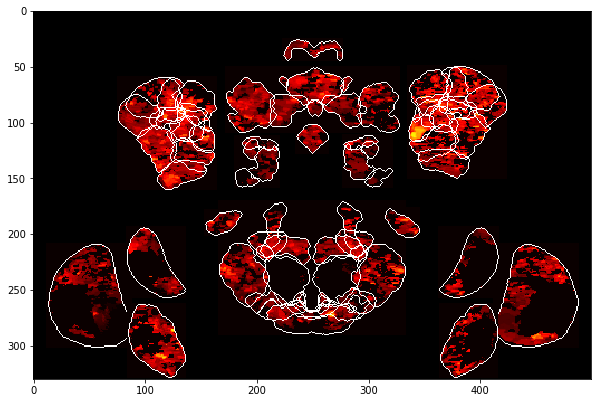

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(explosions[4][170:,:])